In [2]:
import numpy as np
import networkx as nx
import pandas as pd
import random 
import matplotlib.pyplot as plt

## Useful links regarding assignment, repository and data
- data : http://snap.stanford.edu/data/ca-GrQc.html
- assignment : https://docs.google.com/presentation/d/1xWByuPJcIubdVqwNmKueawuxsWL0bpvKHAFQ5lRd2VM/edit#slide=id.geec04a3a8b_0_100

In [118]:
graph_data = pd.read_csv("data.txt", delimiter = "\t")

In [119]:
print("total nodes = 5242")
print("total edges = 28980")
print()
print("edge list")
print()
print(graph_data.head())

total nodes = 5242
total edges = 28980

edge list

   FromNodeId  ToNodeId
0        3466       937
1        3466      5233
2        3466      8579
3        3466     10310
4        3466     15931


## Creating the graph with colors

#### Generating 'K' random colors
- Source : https://stackoverflow.com/questions/28999287/generate-random-colors-rgb

In [164]:
K = 3
colors = list(range(K))
print("number of colors = ", len(colors))

number of colors =  3


In [165]:
nodeIDs = np.unique(graph_data["FromNodeId"])

node_colors = dict()
color_nodes = dict()

for i in nodeIDs:
    node_colors[i] = colors[i%K]
    if(len(node_colors)%K == 0):
        np.random.shuffle(colors)
    # color_nodex[i]


In [166]:
print("number of unique colors of nodes = ", len(np.unique(list(node_colors.values()))))

number of unique colors of nodes =  3


#### Picking nodes with a single color

color ID =  0
the nodes with color = 0  are 



<BarContainer object of 3 artists>

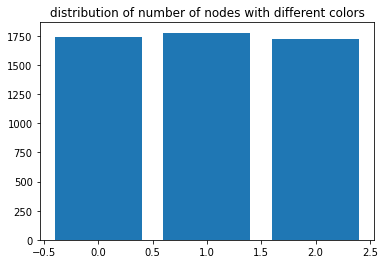

In [181]:
color_id = colors[0]
print("color ID = ",color_id)
nodes = [k for k,v in node_colors.items() if v == color_id]
print("the nodes with color =",color_id ," are ")

print()

node_dist = []
for i in range(len(colors)):
    nodes = [k for k,v in node_colors.items() if v == colors[i]]
    node_dist.append(len(nodes))

plt.title("distribution of number of nodes with different colors")
plt.bar(colors,node_dist)


## Applying Chiba-Nishizeki Algorithm

- Paper : http://www.ecei.tohoku.ac.jp/alg/nishizeki/sub/j/DVD/PDF_J/J053.pdf
- we apply the algorithm to find the number of triangles 

![chiba nishizeki algorithm](cn.png)

#### Picking nodes of same color

In [239]:

def degree_sorted_nodes(dictionary): # sorts the nodes in decreasing order of their degrees
    return {k: v for k, v in sorted(dictionary.items(), key=lambda item: item[1], reverse = True)}


def delete_nodes(edge_list, nodes): #deletes the nodes from the edgelist
    for node in nodes:
        edge_list[edge_list["FromNodeId"] != node]
        edge_list[edge_list["ToNodeId"]   != node]
    return edge_list


def get_subgraph_edgelist(data):    
    edge_list     = data["edge list of graph"]
    nodes         = data["degree sorted nodes"]
    subgraph      = edge_list.loc[edge_list['FromNodeId'].isin(list(nodes.keys()))] 
    data["one color edge list of graph"] = subgraph.loc[subgraph['ToNodeId'].isin(list(nodes.keys()))]
    return data

def check_triangle(data):
    fn_edgelist     = data["first neighbour edgelist"]
    first_neighbour = data["first neighbour"]
    current_node    = data["current node"]
    edgelist        = data["same color edgelist"]
    deleted_nodes   = data["deleted nodes"]

    second_neighbours = list(fn_edgelist[fn_edgelist["FromNodeId"]==first_neighbour]["ToNodeId"])

    for second_neighbour in second_neighbours:
        if(second_neighbour not in deleted_nodes and second_neighbour != current_node and second_neighbour != first_neighbour):
            second_neighbour_edgelist = list(edgelist[edgelist["FromNodeId"]==second_neighbour]["ToNodeId"])

            if(current_node in second_neighbour_edgelist):
                data["second neighbour"] = second_neighbour

                return data, "yes"

    return data, "no"

def update_nodeIDs(nodeIDs, data):
    nodeIDs.remove(data["first neighbour"])
    nodeIDs.remove(data["second neighbour"])
    nodeIDs.remove(data["current node"])
    return nodeIDs


def find_triangles_oneColor(data):                         # finds triangles in one color nodes

    edge_list     = data["one color edge list of graph"]   # (dataframe : "FromNodeId", "ToNodeId")       --- edgelist of the one colored nodes
    nodes         = data["degree sorted nodes"]            # (key : nodeID, Value : Degree of the node)   --- nodes of one single color

    count_triangles = 0
    deleted_nodes = []                                     # list of nodes deleted as they are part of some triangle

    print("total nodes = ", len(nodes))
    nodeIDs = list(nodes.keys())

    data2 = dict()
    for node in nodeIDs:                                   # exploring each node
        node_neighbours = list(edge_list[edge_list["FromNodeId"] == node]["ToNodeId"])
        if(node not in deleted_nodes):
 
            for first_neighbour in node_neighbours:        # exploring neighbours of same color. 
                if(first_neighbour not in deleted_nodes and first_neighbour != node):
                    one_node_edgelist = edge_list[edge_list["FromNodeId"]==first_neighbour]
    
                    data2["first neighbour edgelist"] = one_node_edgelist   
                    data2["current node"]             = node 
                    data2["first neighbour"]          = first_neighbour
                    data2["same color edgelist"]      = edge_list
                    data2["deleted nodes"]            = deleted_nodes

                    data2, triangle_found = check_triangle(data2)

                    if(triangle_found =="yes"):
                        deleted_nodes.append(data2["current node"])
                        deleted_nodes.append(data2["first neighbour"])
                        deleted_nodes.append(data2["second neighbour"])

                        # print("\n current node = ", data2["current node"])
                        # print("first neighbour  = ", data2["first neighbour"])
                        # print("second neighbour = ", data2["second neighbour"])

                        nodeIDs = update_nodeIDs(nodeIDs, data2)
                        count_triangles+=1

                        break
    
    print("triangle count in this colored nodes = ", count_triangles)
    return count_triangles
    # print("deleted nodes = ", deleted_nodes)

    # contains_duplicates = [x for i, x in enumerate(deleted_nodes) if i != deleted_nodes.index(x)]
    # print("number of duplicate nodes = ",contains_duplicates) 


In [246]:
def check_subgraph_colors(data):
    edgelist  = data["one color edge list of graph"]
    node_list = list(data["degree sorted nodes"].keys())

    from_nodes = list(edgelist["FromNodeId"])
    to_nodes   = list(edgelist["ToNodeId"])

    for i in from_nodes:
        if(i not in node_list):
            print("nodes are not of same color")
            return

    for i in to_nodes:
        if(i not in node_list):
            print("nodes are not of same color")
            return

    # print("nodes are of same color")


def get_color_distribution(colors, node_colors):
    node_dist = []
    for i in range(len(colors)):
        nodes = [k for k,v in node_colors.items() if v == colors[i]]
        node_dist.append(len(nodes))

    plt.title("distribution of number of nodes with different colors")
    plt.bar(colors,node_dist)

In [249]:
def triangle_packing(data):

    graph_data = data["edgelist"]
    num_colors = data["K"]
    count_triangles = 0
    colors = list(range(num_colors))

    nodeIDs = np.unique(graph_data["FromNodeId"])

    node_colors = dict()

    for i in nodeIDs:
        node_colors[i] = colors[i%K]
        if(len(node_colors)%K == 0 and data["shuffle"] == True):
            np.random.shuffle(colors)

    get_color_distribution(colors, node_colors)

    for color in colors:
        color_id = color
        # print("color ID = ",color_id)

        one_color_nodes = [k for k,v in node_colors.items() if v == color_id]
        # print("total nodes in this color = ", len(one_color_nodes), "\n")

        c1_node_degree = dict()
        for x in one_color_nodes:
            c1_node_degree[x] = graph_data[graph_data["FromNodeId"] == x].shape[0]

        sorted_node_degree = degree_sorted_nodes(c1_node_degree)
        # nodes are now sorted based on their degrees
        # Need edge list of nodes of same color. We have node IDs of same color nodes.

        data1 = {
                    "degree sorted nodes" : sorted_node_degree, 
                    "edge list of graph"  : graph_data
                }

        data1 = get_subgraph_edgelist(data1)
        one_color_edgelist = data1["one color edge list of graph"]

        check_subgraph_colors(data1)
        count_triangles += find_triangles_oneColor(data1)

    print("_____________________________________________________")
    print("total triangles = ",count_triangles)
    print("_____________________________________________________")


total nodes =  184
triangle count in this colored nodes =  0
total nodes =  197
triangle count in this colored nodes =  1
total nodes =  189
triangle count in this colored nodes =  3
total nodes =  159
triangle count in this colored nodes =  0
total nodes =  171
triangle count in this colored nodes =  0
total nodes =  173
triangle count in this colored nodes =  1
total nodes =  156
triangle count in this colored nodes =  0
total nodes =  169
triangle count in this colored nodes =  0
total nodes =  174
triangle count in this colored nodes =  0
total nodes =  148
triangle count in this colored nodes =  0
total nodes =  168
triangle count in this colored nodes =  2
total nodes =  191
triangle count in this colored nodes =  1
total nodes =  193
triangle count in this colored nodes =  4
total nodes =  179
triangle count in this colored nodes =  0
total nodes =  171
triangle count in this colored nodes =  1
total nodes =  163
triangle count in this colored nodes =  1
total nodes =  163
trian

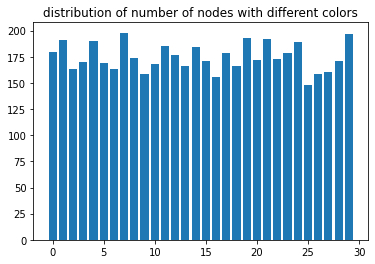

In [256]:
data = {
        "edgelist" : graph_data,
        "K"        : 30,
        "shuffle"  : True
        }

triangle_packing(data)